# Evaluation of ResNet models
In this notebook we evaluate the performance of the model trained in `01_Img2LUT_CNN_BW_LUT` on 400 Kodak Ektar images
pulled from AnalogDB and the same images edited with the black and white LUT.

In this Notebook we compare the performance of two models, one trained without interpolation used for the application of the 3D LUTs and the other with trilinear interpolation.

AnalogDB: https://analogdb.com/about

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
from PIL import Image
from IPython.display import display
import os
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.utils as vutils
import torch.nn.functional as F

In [5]:
eval_experiment = "bw_wo_interpolation"
eval_filepath = "img2lut_bw_wo_interpolation.pth.tar"
learning_rate = 0.001
batch_size=64

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(residual)
        return F.relu(out)

In [8]:
class ResNetLUTGenerator(nn.Module):
    def __init__(self, lut_size=8, trilinear=True, input_channels=3):
        super(ResNetLUTGenerator, self).__init__()
        self.lut_size = lut_size
        self.trilinear = trilinear
        
        # Initial convolution
        self.initial_conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        # ResNet feature extraction
        self.layer1 = self._make_layer(32, 64, stride=2)
        self.layer2 = self._make_layer(64, 128, stride=2)
        self.layer3 = self._make_layer(128, 256, stride=2)
        
        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # LUT generator
        self.lut_generator = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, lut_size * lut_size * lut_size * 3)
        )

    def _make_layer(self, in_channels, out_channels, stride):
        return ResidualBlock(in_channels, out_channels, stride)


    def _trilinear_interpolation(self, luts, images):
        # Scale images to be between -1 and 1
        img = (images - 0.5) * 2.0  # Shape: [4, 3, 256, 256]
    
        # Add a singleton dimension to represent "channel" for LUT interpolation
        img = img.permute(0, 2, 3, 1).unsqueeze(1)  # Shape: [4, 1, 256, 256, 3]
    
        # Ensure LUT is in the correct format
        LUT = luts.permute(0, 4, 1, 2, 3)  # Shape: [4, 3, 8, 8, 8]
    
        # Perform grid sampling for each channel
        result = F.grid_sample(LUT, img, mode='bilinear', padding_mode='border', align_corners=True)  # [4, 3, 1, 256, 256]
    
        # Remove the singleton dimension and permute to the correct format
        result = result.squeeze(2)  # Remove the extra "depth" dimension: [4, 3, 256, 256]
    
        return result

    def _simple_approach(self, luts, images):
        lut = luts.view(luts.shape[0], luts.shape[2], luts.shape[2], luts.shape[2], 3)
        image_normalized = (images * luts.shape[2]-1).long()
        image_normalized = torch.clamp(image_normalized, 0, luts.shape[2]-1)
            
        r = image_normalized[:, 0, :, :]
        g = image_normalized[:, 1, :, :]
        b = image_normalized[:, 2, :, :]
            
        transformed = lut[torch.arange(luts.shape[0]).unsqueeze(-1).unsqueeze(-1), r, g, b]
        transformed = transformed.permute(0, 3, 1, 2)

        return transformed


    def forward(self, x):
        # Feature extraction
        x_orig = x  # Store original input
        x = self.initial_conv(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        # Global pooling and feature compression
        features = self.global_pool(x).view(x.size(0), -1)
        
        # Generate LUT
        lut = self.lut_generator(features)
        lut = lut.view(-1, self.lut_size, self.lut_size, self.lut_size, 3)
        lut = torch.sigmoid(lut)
        
        # Apply LUT to original input
        if self.trilinear:
            transformed = self._trilinear_interpolation(lut, x_orig)
        else:
            transformed = self._simple_approach(lut, x_orig)
        return transformed, lut

### Load model

In [9]:
eval_model = ResNetLUTGenerator(lut_size=33, trilinear=False).to(device)
eval_optimizer = optim.Adam(eval_model.parameters(), lr=learning_rate)

In [10]:
def load_checkpoint(model, optimizer, experiment, filepath):
    
    filepath = f"models/{experiment}/{filepath}"
    print(f"=> Loading checkpoint from {filepath}")
    checkpoint = torch.load(filepath, weights_only=True)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    return model, optimizer

In [11]:
eval_generator, _ = load_checkpoint(eval_model, eval_optimizer, eval_experiment, eval_filepath)

=> Loading checkpoint from models/bw_wo_interpolation/img2lut_bw_wo_interpolation.pth.tar


### Load model that was trained with interpolation as comparison

In [12]:
eval_experiment2 = "bw_w_interpolation"
eval_filepath2 = "img2lut_bw_w_interpolation.pth.tar"
eval_model2 = ResNetLUTGenerator(lut_size=33, trilinear=True).to(device)
eval_optimizer2 = optim.Adam(eval_model2.parameters(), lr=learning_rate)
eval_generator_interpol, _ = load_checkpoint(eval_model2, eval_optimizer2, eval_experiment2, eval_filepath2)

=> Loading checkpoint from models/bw_w_interpolation/img2lut_bw_w_interpolation.pth.tar


In [13]:
class PairedImageDataset(Dataset):
    def __init__(self, ungraded_images, graded_images, transform=None):
        self.ungraded_images = ungraded_images
        self.graded_images = graded_images
        self.transform = transform

    def __len__(self):
        return len(self.ungraded_images)

    def __getitem__(self, idx):
        # Returns an ungraded and a graded image
        ungraded = self.ungraded_images[idx]
        graded = self.graded_images[idx]
        if self.transform:
            ungraded = self.transform(ungraded)
            graded = self.transform(graded)
        return ungraded, graded

In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [15]:
transform64 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

## Is the generated LUT always the same?

In [16]:
luts = []
for i in range(5):
    sample_input = torch.rand(1, 3, 64, 64).to(device)
    _, lut = eval_model(sample_input)
    luts.append(lut)

In [17]:
total_difference = sum(torch.sum(torch.abs(luts[i] - luts[j])) for i in range(len(luts)) for j in range(i + 1, len(luts)))

print(f"Total sum of differences: {total_difference}")

Total sum of differences: 1890.470703125


The generated LUT appears to be image adaptive / not always the same.

## Performance on test images

In [18]:
def load_images_from_directory(directory_path, num_images=100, apply_transform=True):
    images = []
    files = os.listdir(directory_path)
    # Ensure only images are processed
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for i, image_file in enumerate(image_files[:num_images]):
        image_path = os.path.join(directory_path, image_file)
        img = Image.open(image_path).convert('RGB')  # Convert to RGB in case of grayscale
        if apply_transform:
            img = transform64(img)  # Apply the transformations

        else:
            img = transform(img)
        images.append(img)
        
    images_tensor = torch.stack(images)
    images_tensor = images_tensor.permute(0, 2, 3, 1)
    return images_tensor

ungraded_images = load_images_from_directory('../../analogdb_images_scaled/kodak_ektar', num_images=400)
graded_images = load_images_from_directory('../../analogdb_images_scaled/kodak_ektar/BW', num_images=400)

# Verify the shape of the tensors
print(ungraded_images.shape)  
print(graded_images.shape)

torch.Size([400, 256, 256, 3])
torch.Size([400, 256, 256, 3])


In [19]:
ungraded_images_np = ungraded_images.numpy()
graded_images_np = graded_images.numpy()

dataset = PairedImageDataset(ungraded_images_np, graded_images_np, transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [20]:
ungraded, graded = next(iter(dataloader))

In [21]:
ungraded = ungraded.to(device)
edited_images, luts = eval_generator(ungraded)
edited_images_interpol, luts = eval_generator_interpol(ungraded)

In [22]:
def calc_mse(images1, images2):
    mse = torch.mean((images1 - images2) ** 2)
    return mse

In [23]:
mse = calc_mse(graded.to(device),edited_images)
mse_interpol = calc_mse(graded.to(device),edited_images_interpol)

In [24]:
print(mse)
print(mse_interpol)

tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)


In [25]:
print(f"Difference between MSE:{mse-mse_interpol}")

Difference between MSE:0.00017345801461488008


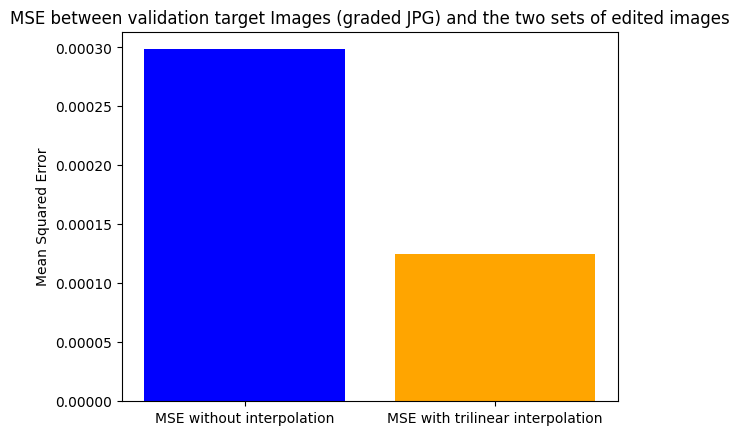

In [26]:
labels = ['MSE without interpolation', 'MSE with trilinear interpolation']
values = [mse.cpu().item(), mse_interpol.cpu().item()]

plt.bar(labels, values, color=['blue', 'orange'])

# Add labels and title
plt.ylabel('Mean Squared Error')
plt.title('MSE between validation target Images (graded JPG) and the two sets of edited images')

plt.show()

In [27]:
def display_image(image, width=256):
    tensor_image = image.detach().cpu()
    # Rearrange to HWC format and scale to [0, 255]
    image_np = np.transpose(tensor_image.numpy(), (1, 2, 0))  # Select the first image in batch and permute to HWC
    image_np = (image_np * 255).clip(0, 255).astype(np.uint8)
            
    image = Image.fromarray(image_np)
    display(image)

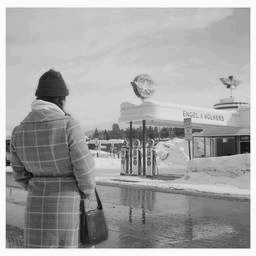

In [28]:
display_image(edited_images[0])

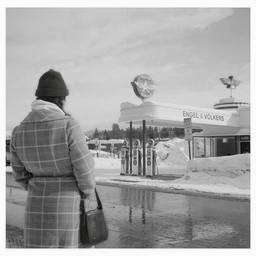

In [29]:
display_image(edited_images_interpol[0])

## Conclusion
The MSE on the validation target images is significantly smaller using the model trained with trilinear interpolation compared to the model without any interpolation (~0.0001 compared to ~0.0003). \
This result is also replicated in the edited images displayed above. \
In the sky we can see a lot more artifacts and broken color transitions in the first image processed by the model without interpolation as in the second image processed with trilinear interpolation. \
We can therefore conclude that as the trilinear interpolation also outperforms our simple approach in training times that it is the preferable method to be used in our trainings.

## Test of the application of a LUT to an image
As it is the aim of our architecture to learn the 3D LUT based on a reduced resolution image of our original file and than apply that 3D LUT to the original file we test if we can apply the LUT to an image independent of the model.

In [30]:
def apply_lut_to_image_interpolation(image, lut, lut_size):
    """
    Applies the LUT to the image using trilinear interpolation for better quality.
    
    Args:
        image: PIL Image in RGB format
        lut: 3D LUT array of shape (lut_size, lut_size, lut_size, 3)
        lut_size: Size of the LUT cube
    """
    tensor_image = image.detach().cpu()

    image_np = np.transpose(tensor_image.numpy(), (1, 2, 0))  # Select the first image in batch and permute to HWC
    image_np = (image_np * 255).clip(0, 255).astype(np.uint8)
            
    image = Image.fromarray(image_np)
    
    # Convert image to RGB numpy array
    image = image.convert("RGB")
    image_data = np.array(image).astype(np.float32) / 255.0
    
    # Scale factors for the LUT
    scale = (lut_size - 1)
    scaled_data = image_data * scale
    
    # Get the floor and ceil indices for interpolation
    floor_idx = np.floor(scaled_data).astype(int)
    ceil_idx = np.minimum(floor_idx + 1, lut_size - 1)
    
    # Calculate interpolation weights
    alpha = scaled_data - floor_idx
    
    # Get the 8 neighboring points in the LUT
    c000 = lut[floor_idx[..., 0], floor_idx[..., 1], floor_idx[..., 2]]
    c001 = lut[floor_idx[..., 0], floor_idx[..., 1], ceil_idx[..., 2]]
    c010 = lut[floor_idx[..., 0], ceil_idx[..., 1], floor_idx[..., 2]]
    c011 = lut[floor_idx[..., 0], ceil_idx[..., 1], ceil_idx[..., 2]]
    c100 = lut[ceil_idx[..., 0], floor_idx[..., 1], floor_idx[..., 2]]
    c101 = lut[ceil_idx[..., 0], floor_idx[..., 1], ceil_idx[..., 2]]
    c110 = lut[ceil_idx[..., 0], ceil_idx[..., 1], floor_idx[..., 2]]
    c111 = lut[ceil_idx[..., 0], ceil_idx[..., 1], ceil_idx[..., 2]]

    # Perform trilinear interpolation
    c00 = c000 * (1 - alpha[..., 2:]) + c001 * alpha[..., 2:]
    c01 = c010 * (1 - alpha[..., 2:]) + c011 * alpha[..., 2:]
    c10 = c100 * (1 - alpha[..., 2:]) + c101 * alpha[..., 2:]
    c11 = c110 * (1 - alpha[..., 2:]) + c111 * alpha[..., 2:]
    
    c0 = c00 * (1 - alpha[..., 1:2]) + c01 * alpha[..., 1:2]
    c1 = c10 * (1 - alpha[..., 1:2]) + c11 * alpha[..., 1:2]
    
    interpolated = c0 * (1 - alpha[..., 0:1]) + c1 * alpha[..., 0:1]
    
    # Convert back to uint8 with proper rounding
    output = np.clip(interpolated * 255.0, 0, 255)
    output = np.round(output).astype(np.uint8)
    
    return Image.fromarray(output)

In [31]:
interpolated_image = apply_lut_to_image_interpolation(ungraded[0].cpu(), luts[0].detach().cpu().numpy(), lut_size=33)

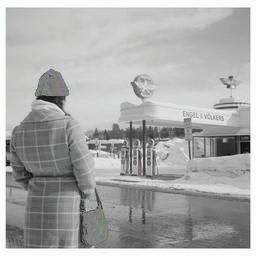

In [32]:
display(interpolated_image)

As we can see above the application of the generated LUT to an image of our validation dataset worked as intended.